# Backtest & Risk Management

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_NIM_LOG_LEVEL'] = '5'

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## Trading Bot

In [2]:
# import sys
# sys.path.append('/Users/afirez/studio/python/auto-trade/modules/aiif/code/finance.py')
import finance
import tradingbot

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [3]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [4]:
a = 0
b = 1750
c = 250

In [5]:
learn_env = finance.Finance(
    symbol, features,window=20, lags=3,
    leverage=1, min_performance=0.9, min_accuracy=0.475,
    start=a, end=a + b, mu=None, std=None
    )

In [6]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


In [8]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [9]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [11]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [13]:
episodes = 61

In [14]:
%time agent.learn(episodes)

/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 10/61 | VALIDATION | treward:  247 | perf: 0.955 | eps: 0.95
episode: 20/61 | VALIDATION | treward:  247 | perf: 0.992 | eps: 0.86
episode: 30/61 | VALIDATION | treward:  247 | perf: 1.114 | eps: 0.78
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.989 | eps: 0.70
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.954 | eps: 0.64
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.916 | eps: 0.58
episode: 61/61 | treward:   16 | perf: 0.997 | av:  92.3 | max: 1747
CPU times: user 1min 4s, sys: 4.53 s, total: 1min 9s
Wall time: 1min


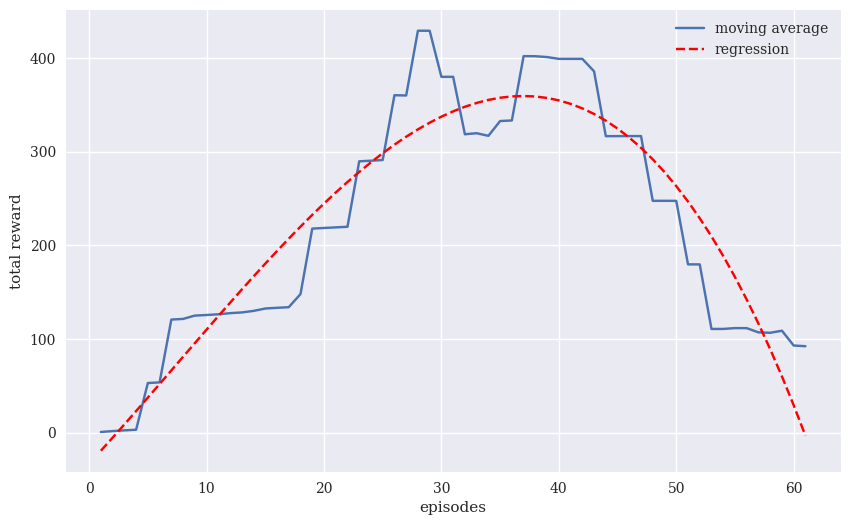

In [15]:
tradingbot.plot_treward(agent)

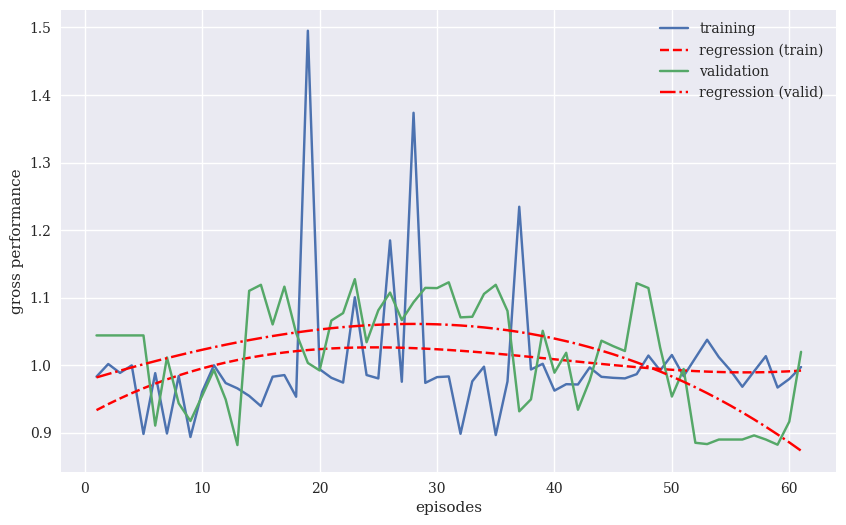

In [16]:
tradingbot.plot_performance(agent)

## Vectorized Backtesting

In [17]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags, learn_env.n_features])

In [18]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0]
        )
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [20]:
env = agent.learn_env

In [21]:
backtest(agent, env)

In [22]:
env.data['p'].iloc[env.lags:].value_counts()

-1    1320
 1     427
Name: p, dtype: int64

In [23]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.7725
s   1.7750
dtype: float64

In [25]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) -1

r   -0.2275
s    0.7750
dtype: float64

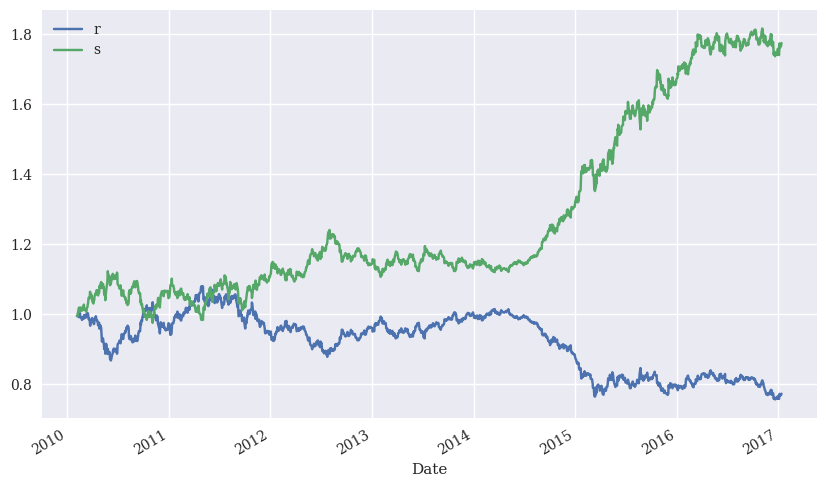

In [26]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [27]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [28]:
env = test_env

In [29]:
backtest(agent, env)

In [30]:
env.data['p'].iloc[env.lags:].value_counts()

-1    405
 1     88
Name: p, dtype: int64

In [31]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.9144
s   1.1812
dtype: float64

In [32]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.0856
s    0.1812
dtype: float64

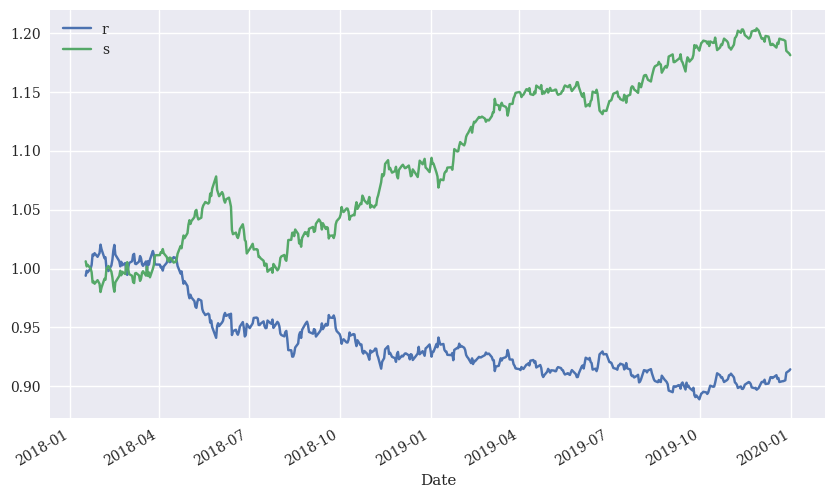

In [33]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Event-Based Backtesting

In [34]:
import backtesting as bt

In [36]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
    amount=10000, ptc=0.0001, ftc=1.0, 
    verbose=True)

In [37]:
bb.initial_amount

10000

In [38]:
bar = 100

In [39]:
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [40]:
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.0242,-0.5622,-0.0916,-0.2022,1.5316
2010-06-23,0.0176,0.6940,-0.0939,-0.0915,1.5563
2010-06-24,0.0354,0.3034,-0.0865,0.6391,1.0890


In [41]:
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 4999.40


In [42]:
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10450.17


In [44]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6347.47


In [45]:
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10733.97
2011-04-11 | net performance [%] = 7.3397
2011-04-11 | number of trades [#] = 3


In [46]:
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        ''' Helper method to reshape state objects
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    def backtest_strategy(self):
        ''' Event-based backtesting of the trading bot's performance.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount 
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            state = self.env.get_state(bar)
            action = np.argmax(self.model.predict(
                self._reshape(state.values))[0, 0]
                )
            position = 1 if action == 1 else -1
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append(
                (date, self.calculate_net_wealth(price))
                )
        self.net_wealths = pd.DataFrame(self.net_wealths, columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(self.net_wealths.index)
        self.close_out(bar)

In [47]:
env = learn_env

In [48]:
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)

In [49]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 7725.42
2017-01-12 | net performance [%] = -22.7458
2017-01-12 | number of trades [#] = 855


In [50]:
tb_ = TBBacktester(env, agent.model, 10000, 0.00012, 0.0, verbose=False)

In [51]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 7723.28
2017-01-12 | net performance [%] = -22.7672
2017-01-12 | number of trades [#] = 855


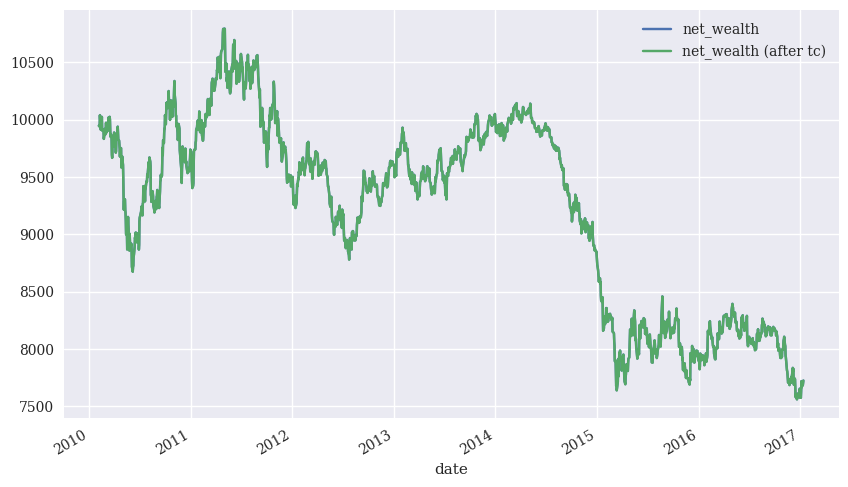

In [52]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [53]:
env = test_env

In [54]:
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)

In [55]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9008.16
2019-12-31 | net performance [%] = -9.9184
2019-12-31 | number of trades [#] = 178


In [56]:
tb_ = TBBacktester(env, agent.model, 10000, 0.00012, 0.00, verbose=False)

In [57]:
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9003.71
2019-12-31 | net performance [%] = -9.9629
2019-12-31 | number of trades [#] = 178


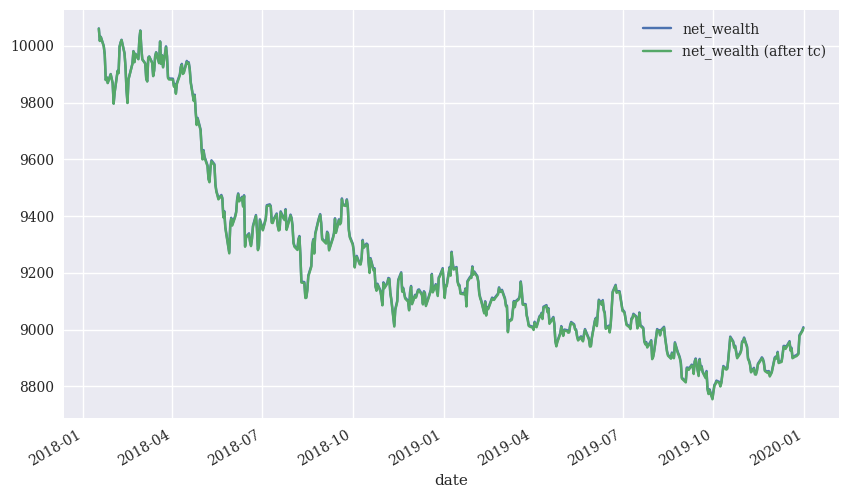

In [58]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

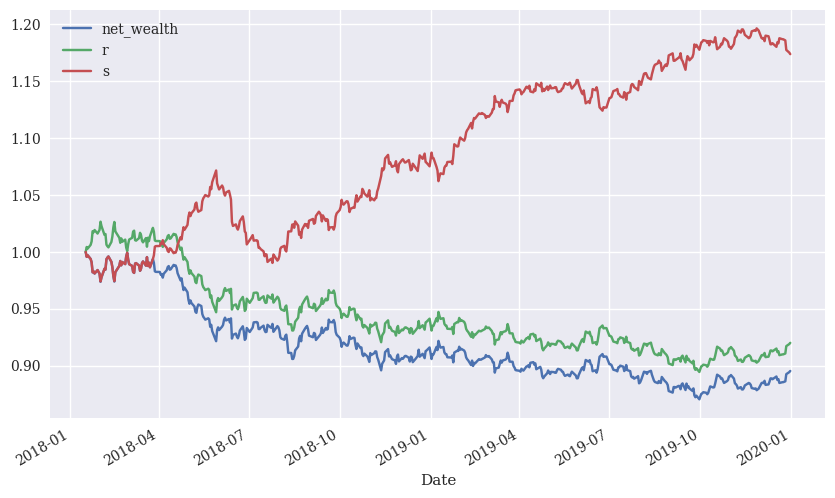

In [59]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10,6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp /tp.iloc[0]).plot(ax=ax);

## Assessing Risk

In [60]:
data = pd.DataFrame(learn_env.data[symbol])

In [61]:
data.head()

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


In [62]:
window = 14

In [63]:
data['min'] = data[symbol].rolling(window).min()

In [64]:
data['max'] = data[symbol].rolling(window).max()

In [65]:
data['mami'] = data['max'] - data['min']

In [66]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [67]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [68]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [69]:
data['atr'] = np.maximum(data['atr'], data['mic'])

In [70]:
data['atr%'] = data['atr'] / data[symbol]

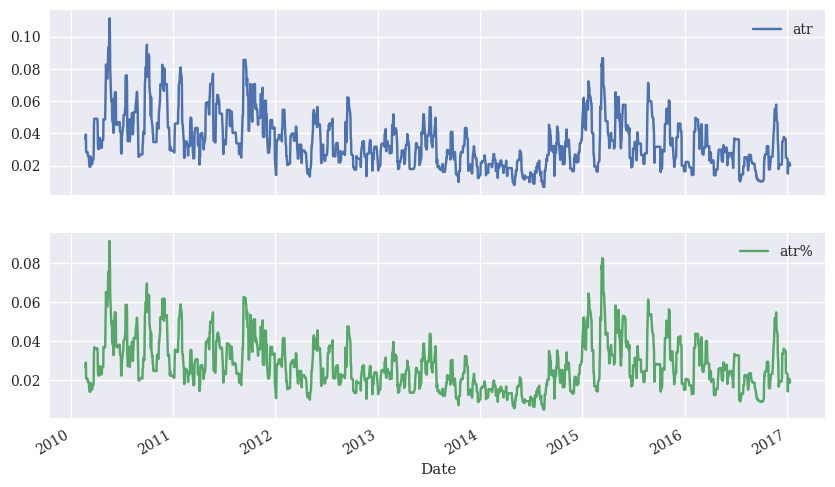

In [71]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));

In [73]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,0.0218,0.0207
2017-01-09,0.0218,0.0206
2017-01-10,0.0218,0.0207
2017-01-11,0.0199,0.0188
2017-01-12,0.0206,0.0194


In [74]:
leverage = 10

In [75]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,0.2180,0.2070
2017-01-09,0.2180,0.2062
2017-01-10,0.2180,0.2066
2017-01-11,0.1990,0.1881
2017-01-12,0.2060,0.1942


## Backtesting Risk Measures

In [79]:
import tbbacktesterrm as tbbrm

In [80]:
env = test_env

In [81]:
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000, 0.0, 0, verbose=False)

In [82]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11733.58
2019-12-31 | net performance [%] = 17.3358
2019-12-31 | number of trades [#] = 194


Stop Loss

In [83]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0203) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0198) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0189) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11300.39
2019-12-31 | net performance [%] = 13.0039
2019-12-31 | number of trades [#] = 200


In [84]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11392.78
2019-12-31 | net performance [%] = 13.9278
2019-12-31 | number of trades [#] = 200


Trailing Stop Loss

In [85]:
tb.backtest_strategy(sl=None, tsl=0.015, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0152) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0173) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0170) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0164) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0154) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0158) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0181) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0155) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0160) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11239.99
2019-12-31 | net performance [%] = 12.3999
2019-12

Take Profit

In [86]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015, wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0164) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0167) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0155) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0204) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0157) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0183) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11683.65
2019-12-31 | net performance [%] = 16.8365
2019-12-31 | number of trades [#] = 184


Combinations

In [87]:
tb.backtest_strategy(sl=0.015, tsl=None, tp=0.0185, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0203) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0152) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0189) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0219) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0192) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0154) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0158) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0223) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0162) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | cur

In [88]:
tb.backtest_strategy(sl=None, tsl=0.02, tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0235) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0222) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0202) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0250) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0227) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0214) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0212) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 11031.78
2019-12-31 | net performance [%] = 10.3178
2019-12-31 | number of trades [#] = 196


<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>